# OLS Model Regularization

Andrew Chung, hc893, 4/26/2025

Linear Model Regularization steps for the OLS Linear Model (see `ols.ipynb`).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

**Import Data**

In [2]:
data = pd.read_csv("subwaydata.csv").iloc[:, 1:]  # remove unlabelled index column
X = data.iloc[:, 3:]
y = data['ridership']/1000
# ensure that X and y are equal in size
assert X.shape[0] == y.size, "Non-conformable X and y inputs"

## Model Selection

In [3]:
# Forward selection
sfs_forward = SFS(
  LinearRegression(),
  k_features = 'best', forward = True, floating = False,
  scoring = 'neg_mean_squared_error', cv = 5
).fit(X, np.log(y))

sfs_forward.k_feature_names_

('additional_platform_time',
 'over_five_mins_perc',
 'wait_assessment',
 'terminal_on_time_performance',
 'noninfra_critical',
 'infra_noncritical')

In [4]:
# Backward elimination
sfs_backward = SFS(
  LinearRegression(),
  k_features = 'best', forward = False, floating = False,
  scoring = 'neg_mean_squared_error', cv = 5
).fit(X, np.log(y))

sfs_backward.k_feature_names_

('additional_platform_time',
 'over_five_mins_perc',
 'service_delivered',
 'infra_critical',
 'noninfra_critical')

In [5]:
# Stepwise selection
sfs_stepwise = SFS(
  LinearRegression(),
  k_features = 'best', forward = True, floating = True,
  scoring = 'neg_mean_squared_error', cv = 5
).fit(X, np.log(y))

sfs_stepwise.k_feature_names_

('additional_platform_time',
 'over_five_mins_perc',
 'terminal_on_time_performance',
 'infra_critical',
 'noninfra_critical')

Though the results aren't uniform, the main takeaway is that the 11 performance features can effectively be summed up into three (3) categories: 

1. Service Disruption Severity (Additional Wait/Train Time, % over 5 minutes)
2. Truancy/Timeliness of Service (Wait Assessment, Service Delivered, Terminal On Time %, Percent Late)
3. Incident Count (Critical/Noncritical, Infrastructure/Noninfrastructure)

## L2 (Ridge) Regression

Ridge Regression with LOOCV. (147 : 37 Train : Test split)

Running LOO RidgeCV Regression, with $\lambda \in [10^{-3}, 10^3]$.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
y_train, y_test = np.log(y_train), np.log(y_test)
alphas = np.logspace(-3, 3, 100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
ridge_cv = RidgeCV(alphas=alphas, store_cv_results = True)
ridge_cv.fit(X_train, y_train)
print("Optimal alpha: {}".format(ridge_cv.alpha_))

Optimal alpha: 0.4641588833612782


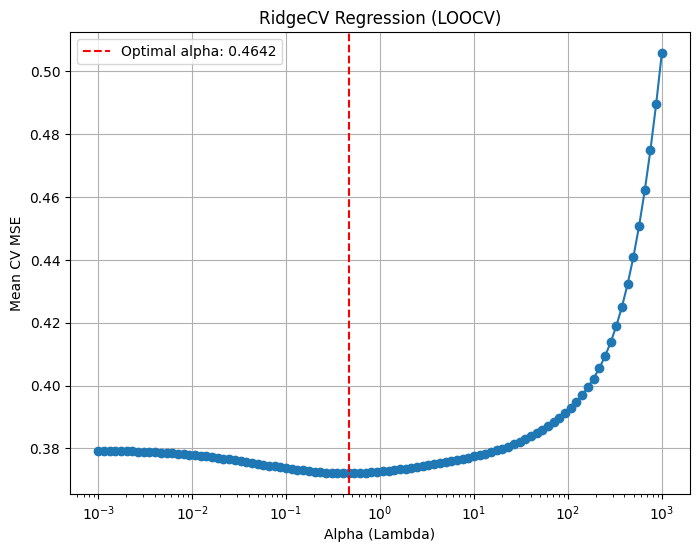

In [8]:
mean_cv_errors = np.mean(ridge_cv.cv_values_, axis=0)

plt.figure(figsize=(8, 6))
plt.semilogx(np.logspace(-3, 3, 100), mean_cv_errors, marker='o')
plt.axvline(ridge_cv.alpha_, linestyle='--', color='red', label=f"Optimal alpha: {ridge_cv.alpha_:.4f}")
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean CV MSE')
plt.title('RidgeCV Regression (LOOCV)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_pred = ridge_cv.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse_ridge:.4f}")

Test MSE: 0.2992


In [10]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)
mse_linreg = mean_squared_error(y_test, y_pred_linreg)
print(f"Linear Regression Test MSE: {mse_linreg:.4f}")

Linear Regression Test MSE: 0.3110


## L1 (Lasso) Regularization

Lasso Regression with 5-fold Cross Validation. (147 : 37 Train : Test split)

In [11]:
lasso_cv = LassoCV(alphas = alphas, cv = 5)
lasso_cv.fit(X_train, y_train)
print("Optimal alpha: {}".format(lasso_cv.alpha_))

Optimal alpha: 0.012328467394420659


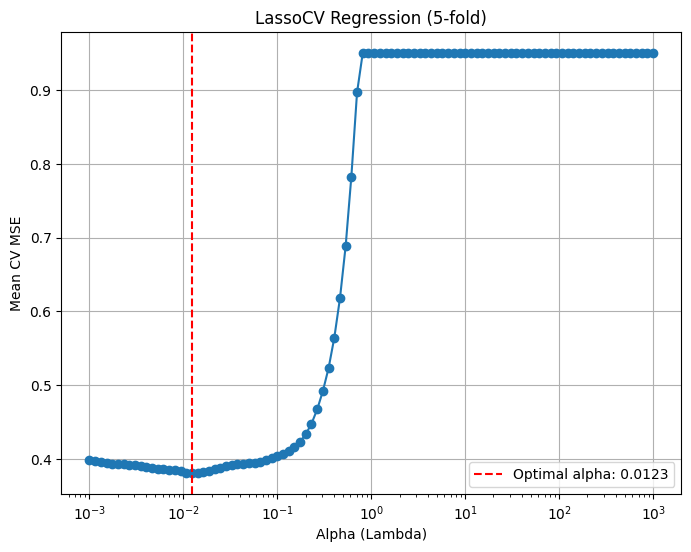

In [12]:
mean_mse_lasso = np.mean(lasso_cv.mse_path_, axis=1)

plt.figure(figsize=(8,6))
plt.semilogx(lasso_cv.alphas_, mean_mse_lasso, marker='o')
plt.axvline(lasso_cv.alpha_, linestyle='--', color='red', label=f"Optimal alpha: {lasso_cv.alpha_:.4f}")
plt.xlabel('Alpha (Lambda)')
plt.ylabel('Mean CV MSE')
plt.title('LassoCV Regression (5-fold)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
y_pred_lasso = lasso_cv.predict(X_test)
lasso_test_mse = mean_squared_error(y_test, y_pred_lasso)
print(f"Lasso: Test MSE = {lasso_test_mse:.4f}")

Lasso: Test MSE = 0.3088
